In [1]:
from imp import reload
import sys
print(sys.version)
# import rpy2
import os
import os.path
import glob
import numpy as np
import pandas as pd
from scipy import stats
#import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm

3.9.0 (default, Nov 21 2020, 14:55:42) 
[Clang 12.0.0 (clang-1200.0.32.27)]


# Plotting the results of the experiments in the paper 
## Which value of $r_1$ (ratio_samples_learn) and $r_2$ (weight_samples_learn) is the best for each instance?

The learning rate $\rho$ (uBorda parameter) is **not** set manually. Instead, we use these two parameters to obtain a more interpretable setting: The value of $\rho$ is set at each iteration and depends on the set of function evaluations $F$. Parameter $\rho$ is set such that the largest $r_1$\% of the mass of the weights is concentrated in the best $r_2$\% of the solutions in $S$, i.e., 

$$
r_1 \sum_{\sigma\in S}\rho^{f(\sigma)} =  \sum_{\sigma\in S'}\rho^{f(\sigma)} \text{where} |S'| = r_2|S| \land \forall \sigma'\in S', \sigma\in S\setminus S' : f(\sigma')\geq f(\sigma)
$$


Therefore, for each instance, we plot the mean of the best fitnesses over 10 repetitions as a function of $r_1$ and $r_2$. Since we are minimizing, the lower the better. 

Overall, the values ($r_1, r_2$)=(.1,.9) have good performance, we will use this configuration for the rest of the experimental section. 

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

The following two cells perform the experiments, in particular:
- the first one run the whole combination of parameters (beware that this takes long because they are lots of executions) and we do not recomment to run here and
- the second one processes the results and generates the plots

In [3]:
# dfselected = pd.read_csv('./best_fitness_selected.txt',sep='\t')
# lis = []
# for inst in dfselected.instance_name.values:#collect all the instance paths
#   for folder in ['./lop/','./pfsp/', './qap/']: 
#       for dirpath, dirnames, filenames in os.walk(folder):
#           for filename in [f for f in filenames ]:
#             if inst in os.path.join(dirpath, filename):
#                 lis.append(os.path.join(dirpath, filename))    
# budget=40#0
# m_ini=10
# budgetMM=10
# res = []
# for instance_name in lis:
#   for r1 in [.1,.2,.3,.4,.5]:
#     for r2 in [.6,.7,.8,.9,.99]:
#       for seed in range(1):
#         out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
#         df = runner.run_once("UMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
#                              ratio_samples_learn = r1, weight_mass_learn = r2, out_filename = out_filename)
#         print(out_filename,r1, r2,df.Fitness.min())
#         res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
#         #os.remove(out_filename)
# FIXME: This does not generate results/results.csv

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


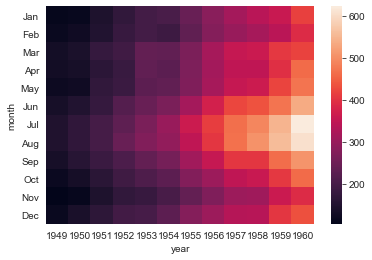

In [36]:
flights = sns.load_dataset("flights")
print(flights.head())
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [38]:
# pd.read_csv('tuning.csv')
df = pd.read_csv('tuning.csv', header=None, sep='\n')
df = df[0].str.split(',', expand=True)
df.columns = df.iloc[0]
df = df[1:]
df = df[[  'instance',       'seed',  'umm_m_ini',   'budgetMM',        'r_1', 'r_2',     'budget', 'eval_ranks',    'fitness']]
df#df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df


0           instance         seed umm_m_ini budgetMM      r_1   r_2 budget  \
1     qap/kra30a.dat           10        10       10      0.2  0.99    400   
2     qap/kra30a.dat            1        10       10      0.2  0.99    400   
3     qap/kra30a.dat            2        10       10      0.2  0.99    400   
4     qap/kra30a.dat            3        10       10      0.2  0.99    400   
5     qap/kra30a.dat            4        10       10      0.2  0.99    400   
...              ...          ...       ...      ...      ...   ...    ...   
2245   LOP-synthetic  seed=123456      n=20    m=200  phi=0.9     5     10   
2246   LOP-synthetic  seed=123456      n=20    m=200  phi=0.9     6     10   
2247   LOP-synthetic  seed=123456      n=20    m=200  phi=0.9     7     10   
2248   LOP-synthetic  seed=123456      n=20    m=200  phi=0.9     8     10   
2249   LOP-synthetic  seed=123456      n=20    m=200  phi=0.9     9     10   

0    eval_ranks   fitness  
1             0  120170.0  
2             0  117170.0  
3             0  113260.0  
4             0  113030.0  
5             0  114050.0  
...         ...       ...  
2245         10       0.5  
2246         10       0.5  
2247         10       0.5  
2248         10       0.5  
2249         10       0.5  

[2249 rows x 9 columns]

In [3]:
df = pd.read_csv('./tuning.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
dfres = df.reset_index()
dfres
for instance_name in dfres.filename.drop_duplicates().values:
    print(instance_name, )
    plt.figure(figsize=(3,2))
    sns.set_style("whitegrid")
    square = dfres[dfres.filename == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
    sns.heatmap(square, cmap="viridis")
    plt.tight_layout()
    plt.xlabel(r'$r_2$')
    plt.ylabel(r'$r_1$')
    plt.savefig('img/heatmap_' + instance_name.replace('.','_') + '.pdf')
    plt.show()

ParserError: Error tokenizing data. C error: Expected 9 fields in line 300, saw 17


## Synthetic datasets (LOP)


  The instances $M$ follow this distribution $M_\phi[i,j]$
  $$M_\phi[i,j] = h(j-i+1,\phi) - h(j-i,\phi),$$ where $$h(k,\phi)=\frac{k}{1-\phi^k} \enspace.$$
  
Taking different values of $\phi$ we controll the uniformity of $M$.
  
In the next cell we plot the results over the synthetic instances

In [10]:
# Compare synthetic data in the same plot.
# Compare the convergence to lowest fitness funtion values by the two solvers
lis = []
for filename in glob.glob("./results-er*/LOP-synthetic*/*.pkl.*z"):
    lis.append(pd.read_pickle(filename))
df = pd.concat(lis, sort = True)
df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
assert((df.groupby(['Solver', 'instance'])['seed'].nunique() == 10).all())
df

Distance  Fitness  Fitness_norm  Function evaluations Problem Solver  \
0    0.373684  101.310      0.552892                     1     LOP   CEGO   
1    0.500000   86.840      0.431601                     2     LOP   CEGO   
2    0.510526   93.160      0.484577                     3     LOP   CEGO   
3    0.505263  111.170      0.635541                     4     LOP   CEGO   
4    0.452632   76.700      0.346605                     5     LOP   CEGO   
..        ...      ...           ...                   ...     ...    ...   
395  0.636842   46.915      0.190871                   396     LOP    UMM   
396  0.636842   70.035      0.339505                   397     LOP    UMM   
397  0.636842   73.175      0.359691                   398     LOP    UMM   
398  0.636842   46.355      0.187271                   399     LOP    UMM   
399  0.636842   57.535      0.259145                   400     LOP    UMM   

     budget  budgetGA  budgetMM  eval_ranks  ... m_ini  phi_estim  phi_sample  \
0       400    1000.0       NaN           0  ...    10        NaN         NaN   
1       400    1000.0       NaN           0  ...    10        NaN         NaN   
2       400    1000.0       NaN           0  ...    10        NaN         NaN   
3       400    1000.0       NaN           0  ...    10        NaN         NaN   
4       400    1000.0       NaN           0  ...    10        NaN         NaN   
..      ...       ...       ...         ...  ...   ...        ...         ...   
395     400       NaN      10.0           1  ...    10   0.443806     0.09375   
396     400       NaN      10.0           1  ...    10   0.430746     0.09375   
397     400       NaN      10.0           1  ...    10   0.429118     0.09375   
398     400       NaN      10.0           1  ...    10   0.429042     0.06250   
399     400       NaN      10.0           1  ...    10   0.414454     0.06250   

     ratio_samples_learn           rho       run_time  seed  \
0                    NaN           NaN  138501.122924     8   
1                    NaN           NaN  138501.122924     8   
2                    NaN           NaN  138501.122924     8   
3                    NaN           NaN  138501.122924     8   
4                    NaN           NaN  138501.122924     8   
..                   ...           ...            ...   ...   
395                  0.1  4.768372e-07     262.689026     2   
396                  0.1  5.960464e-07     262.689026     2   
397                  0.1  5.364418e-07     262.689026     2   
398                  0.1  5.364418e-07     262.689026     2   
399                  0.1  6.556511e-07     262.689026     2   

     weight_mass_learn                                                  x  \
0                  NaN  [10.0, 18.0, 17.0, 0.0, 5.0, 3.0, 16.0, 8.0, 1...   
1                  NaN  [7.0, 13.0, 12.0, 6.0, 11.0, 1.0, 15.0, 16.0, ...   
2                  NaN  [4.0, 2.0, 16.0, 11.0, 8.0, 14.0, 7.0, 9.0, 17...   
3                  NaN  [1.0, 18.0, 12.0, 2.0, 15.0, 9.0, 13.0, 0.0, 3...   
4                  NaN  [14.0, 12.0, 9.0, 17.0, 4.0, 6.0, 5.0, 0.0, 1....   
..                 ...                                                ...   
395                0.9  [18, 2, 1, 17, 19, 13, 16, 14, 12, 7, 9, 4, 10...   
396                0.9  [18, 2, 1, 17, 19, 13, 16, 15, 12, 6, 9, 5, 11...   
397                0.9  [18, 2, 1, 16, 19, 13, 17, 12, 14, 5, 9, 3, 11...   
398                0.9  [18, 2, 1, 17, 19, 14, 16, 13, 12, 6, 11, 4, 1...   
399                0.9  [18, 1, 2, 17, 19, 14, 15, 13, 11, 6, 9, 4, 12...   

    Uniformity  
0          0.7  
1          0.7  
2          0.7  
3          0.7  
4          0.7  
..         ...  
395        0.5  
396        0.5  
397        0.5  
398        0.5  
399        0.5  

[48000 rows x 21 columns]

Since both the maximun and the minimum fitness values are estimators, the fitness values are re-normalized

In [17]:
#maxsol = df.groupby(['instance','seed'])['Fitness'].max().reset_index(name='maxfit')
#df = pd.merge(maxsol, df)
#df['Fitness'] = df.Fitness / df.maxfit

Saving to img/synthetic_LOP_combined_er0.pdf ...


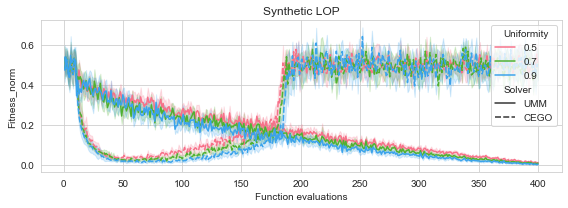

Saving to img/synthetic_LOP_combined_er1.pdf ...


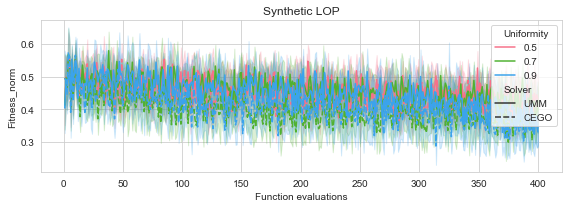

In [5]:
color_variable = 'Uniformity'
y_variables = ['Fitness_norm']
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for name, group in df.groupby('eval_ranks'):
    for y_variable in y_variables:
        plt.figure(figsize=(8,3))
        g = sns.lineplot(x='Function evaluations', y=y_variable, style='Solver', hue=color_variable, data=group,
                         palette=palette)
        g.set_title('Synthetic LOP')
        plt.tight_layout()
        filename = f'img/synthetic_LOP_combined_er{name}.pdf'
        print(f'Saving to {filename} ...')
        plt.savefig(filename)
        plt.show()

## Real datasets (LOP, QAP, PFSP)
In the following lines we load the results of the real dataset for CEGO and UMM, plot the results and make the comparison table

In [16]:
# lis = []
# for folder in ['results-er0/','results-er1/']: 
#   #'results/lop/','results/pfsp/', 'results/qap/'
#     for dirpath, dirnames, filenames in os.walk(folder):
#         for filename in [f for f in filenames if f.endswith(".pkl.gz")]:
#             print("reading: ", (os.path.join(dirpath, filename)))
#             lis.append(pd.read_pickle(os.path.join(dirpath, filename)))
# dfreal = pd.concat(lis)
# selected = pd.read_csv('best_fitness_selected.txt', sep='\s+', comment='#')
# print(selected.instance_name)
# # Only include selected data.
# dfreal = dfreal[dfreal.instance.str.contains('|'.join(selected.instance_name))]
# assert((dfreal.groupby(['Solver', 'instance'])['seed'].nunique() == 10).all())
# dfreal

# Compare synthetic data in the same plot.
# Compare the convergence to lowest fitness funtion values by the two solvers
lis = []
for filename in glob.glob("./results-er*/**/*.pkl.*z", recursive=True): lis.append(pd.read_pickle(filename))
# for filename in glob.glob("./results-er*/*/*/*.pkl.*z"): lis.append(pd.read_pickle(filename))
dfreal = pd.concat(lis, sort = True)
dfreal['Uniformity'] = dfreal.instance.str.extract(r'phi=(.+)$').astype(float)
assert((dfreal.groupby(['Solver', 'instance'])['seed'].nunique() == 10).all())
dfreal


Distance  Fitness  Fitness_norm  Function evaluations Problem Solver  \
0         NaN  86946.0           NaN                     1     LOP    UMM   
1         NaN  84546.0           NaN                     2     LOP    UMM   
2         NaN  86075.0           NaN                     3     LOP    UMM   
3         NaN  86151.0           NaN                     4     LOP    UMM   
4         NaN  85624.0           NaN                     5     LOP    UMM   
..        ...      ...           ...                   ...     ...    ...   
395       NaN   2578.0           NaN                   396    PFSP    UMM   
396       NaN   2596.0           NaN                   397    PFSP    UMM   
397       NaN   2514.0           NaN                   398    PFSP    UMM   
398       NaN   2497.0           NaN                   399    PFSP    UMM   
399       NaN   2538.0           NaN                   400    PFSP    UMM   

     budget  budgetGA  budgetMM  eval_ranks  ... m_ini  phi_estim  phi_sample  \
0       400       NaN      10.0           0  ...    10        NaN         NaN   
1       400       NaN      10.0           0  ...    10        NaN         NaN   
2       400       NaN      10.0           0  ...    10        NaN         NaN   
3       400       NaN      10.0           0  ...    10        NaN         NaN   
4       400       NaN      10.0           0  ...    10        NaN         NaN   
..      ...       ...       ...         ...  ...   ...        ...         ...   
395     400       NaN      10.0           1  ...    10   0.657576     0.09375   
396     400       NaN      10.0           1  ...    10   0.657562     0.09375   
397     400       NaN      10.0           1  ...    10   0.657557     0.06250   
398     400       NaN      10.0           1  ...    10   0.657203     0.06250   
399     400       NaN      10.0           1  ...    10   0.655573     0.06250   

     ratio_samples_learn           rho     run_time  seed  weight_mass_learn  \
0                    0.1           NaN  6848.258202     1                0.9   
1                    0.1           NaN  6848.258202     1                0.9   
2                    0.1           NaN  6848.258202     1                0.9   
3                    0.1           NaN  6848.258202     1                0.9   
4                    0.1           NaN  6848.258202     1                0.9   
..                   ...           ...          ...   ...                ...   
395                  0.1  1.455192e-11   607.106220     4                0.9   
396                  0.1  1.455192e-11   607.106220     4                0.9   
397                  0.1  1.455192e-11   607.106220     4                0.9   
398                  0.1  1.455192e-11   607.106220     4                0.9   
399                  0.1  1.091394e-11   607.106220     4                0.9   

                                                     x Uniformity  
0    [80, 84, 33, 81, 93, 17, 36, 82, 69, 65, 92, 3...        NaN  
1    [44, 96, 1, 35, 26, 11, 38, 82, 87, 3, 50, 0, ...        NaN  
2    [95, 67, 96, 71, 1, 80, 99, 45, 52, 27, 97, 63...        NaN  
3    [40, 10, 96, 66, 89, 32, 95, 55, 25, 5, 0, 7, ...        NaN  
4    [89, 99, 45, 96, 72, 9, 74, 88, 1, 38, 20, 65,...        NaN  
..                                                 ...        ...  
395  [0, 16, 7, 13, 5, 20, 2, 3, 4, 26, 1, 10, 24, ...        NaN  
396  [0, 15, 7, 11, 5, 19, 1, 2, 3, 26, 4, 12, 24, ...        NaN  
397  [1, 18, 7, 12, 5, 17, 2, 3, 4, 27, 0, 11, 23, ...        NaN  
398  [1, 16, 7, 11, 6, 19, 2, 3, 4, 26, 0, 12, 24, ...        NaN  
399  [0, 16, 7, 11, 5, 19, 2, 4, 3, 26, 1, 12, 24, ...        NaN  

[478800 rows x 21 columns]

In [17]:
dfreal.instance.drop_duplicates()

0                          lop/RandA1/N-t1d100.01
0                          lop/RandA1/N-t1d100.02
0                        lop/xLOLIB/N-be75eec_150
0                         lop/xLOLIB/N-be75np_150
0                               lop/IO/N-t59d11xx
0                               lop/IO/N-t59b11xx
0                                lop/Spec/N-pal13
0                                lop/Spec/N-pal11
0                                 lop/MB/N-r100a2
0                                 lop/MB/N-r100b2
0                          lop/RandA2/N-t2d100.02
0                          lop/RandA2/N-t2d100.01
0                              lop/SGB/N-sgb75.01
0                              lop/SGB/N-sgb75.02
0                              lop/RandB/N-p40-02
0                              lop/RandB/N-p40-01
0    LOP-synthetic,seed=123456,n=20,m=200,phi=0.7
0    LOP-synthetic,seed=123456,n=20,m=200,phi=0.9
0                                   qap/tho30.dat
0                                  qap/kra30a.dat


Instance:  lop/RandA1/N-t1d100.01
Saving to img/fitness_real_lop_RandA1_N-t1d100_01.pdf


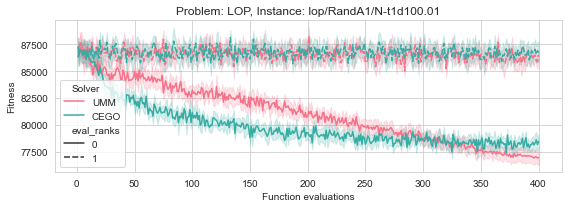

Instance:  lop/RandA1/N-t1d100.02
Saving to img/fitness_real_lop_RandA1_N-t1d100_02.pdf


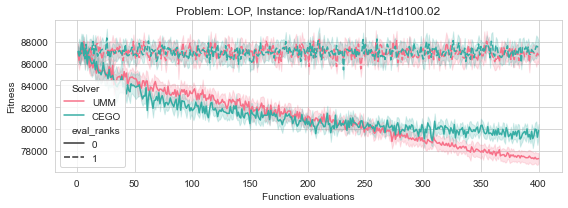

Instance:  lop/xLOLIB/N-be75eec_150
Saving to img/fitness_real_lop_xLOLIB_N-be75eec_150.pdf


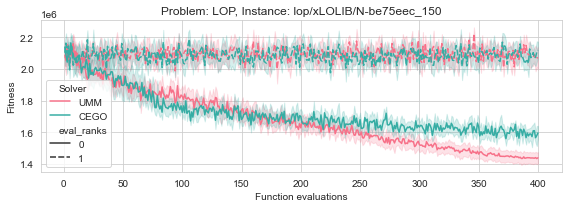

Instance:  lop/xLOLIB/N-be75np_150
Saving to img/fitness_real_lop_xLOLIB_N-be75np_150.pdf


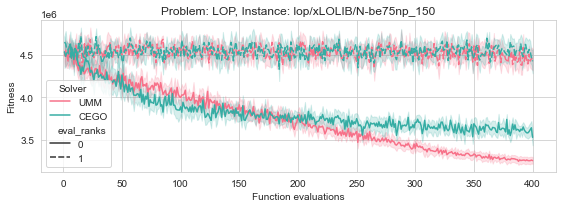

Instance:  lop/IO/N-t59d11xx
Saving to img/fitness_real_lop_IO_N-t59d11xx.pdf


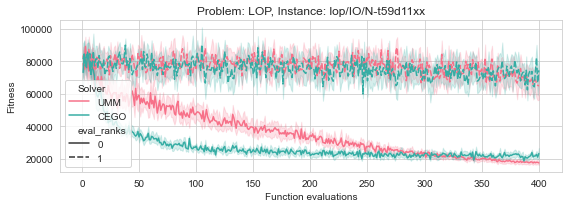

Instance:  lop/IO/N-t59b11xx
Saving to img/fitness_real_lop_IO_N-t59b11xx.pdf


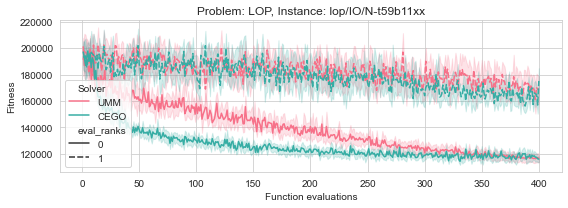

Instance:  lop/Spec/N-pal13
Saving to img/fitness_real_lop_Spec_N-pal13.pdf


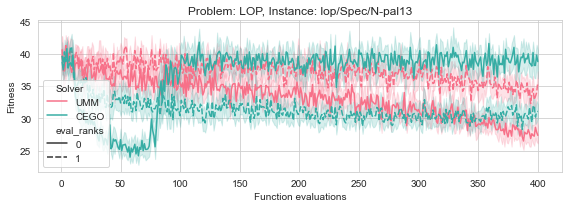

Instance:  lop/Spec/N-pal11
Saving to img/fitness_real_lop_Spec_N-pal11.pdf


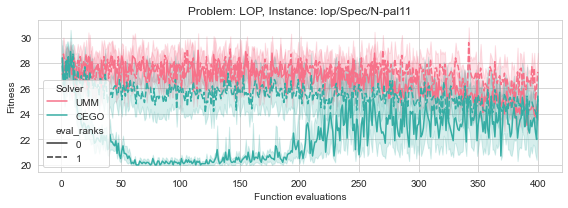

Instance:  lop/MB/N-r100a2
Saving to img/fitness_real_lop_MB_N-r100a2.pdf


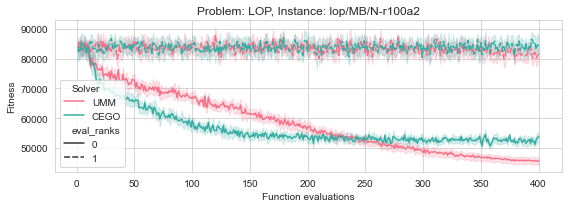

Instance:  lop/MB/N-r100b2
Saving to img/fitness_real_lop_MB_N-r100b2.pdf


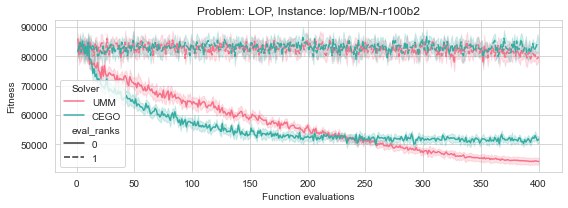

Instance:  lop/RandA2/N-t2d100.02
Saving to img/fitness_real_lop_RandA2_N-t2d100_02.pdf


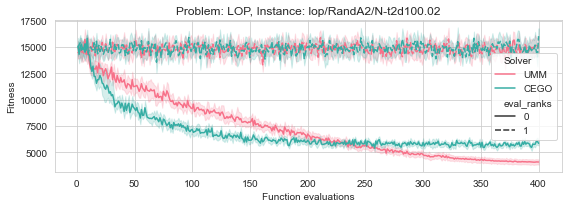

Instance:  lop/RandA2/N-t2d100.01
Saving to img/fitness_real_lop_RandA2_N-t2d100_01.pdf


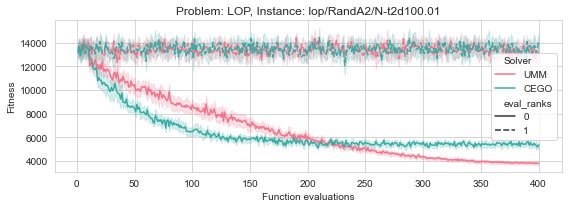

Instance:  lop/SGB/N-sgb75.01
Saving to img/fitness_real_lop_SGB_N-sgb75_01.pdf


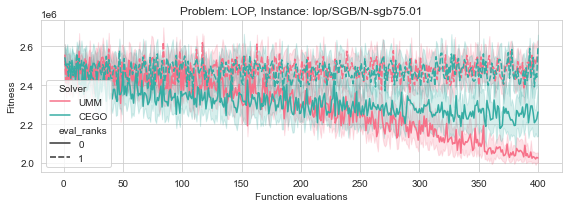

Instance:  lop/SGB/N-sgb75.02
Saving to img/fitness_real_lop_SGB_N-sgb75_02.pdf


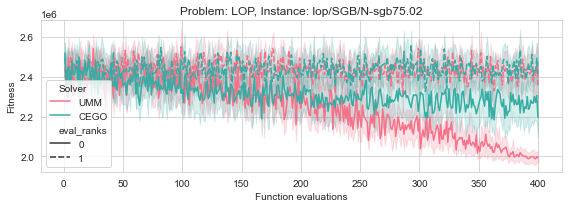

Instance:  lop/RandB/N-p40-02
Saving to img/fitness_real_lop_RandB_N-p40-02.pdf


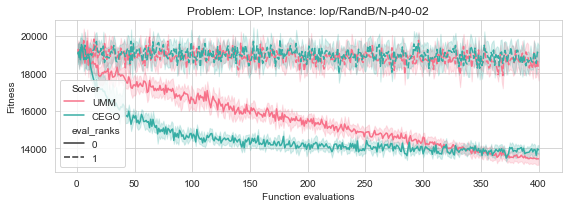

Instance:  lop/RandB/N-p40-01
Saving to img/fitness_real_lop_RandB_N-p40-01.pdf


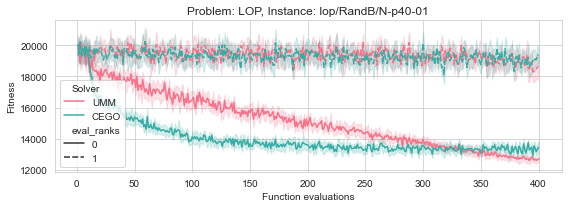

Instance:  LOP-synthetic,seed=123456,n=20,m=200,phi=0.7
Saving to img/fitness_real_LOP-synthetic,seed=123456,n=20,m=200,phi=0_7.pdf


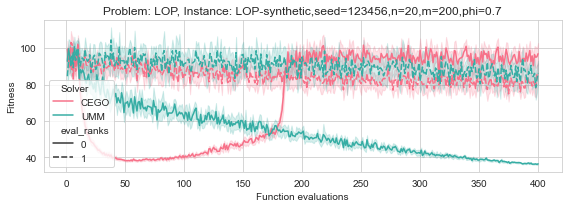

Instance:  LOP-synthetic,seed=123456,n=20,m=200,phi=0.9
Saving to img/fitness_real_LOP-synthetic,seed=123456,n=20,m=200,phi=0_9.pdf


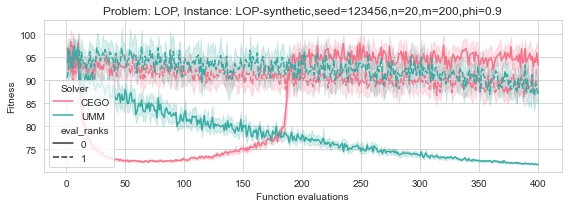

Instance:  qap/tho30.dat
Saving to img/fitness_real_qap_tho30_dat.pdf


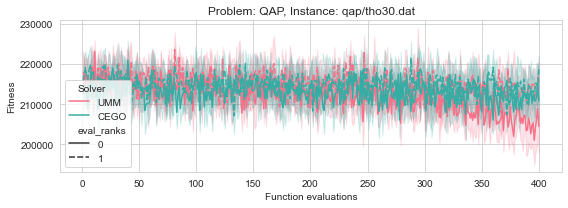

Instance:  qap/kra30a.dat
Saving to img/fitness_real_qap_kra30a_dat.pdf


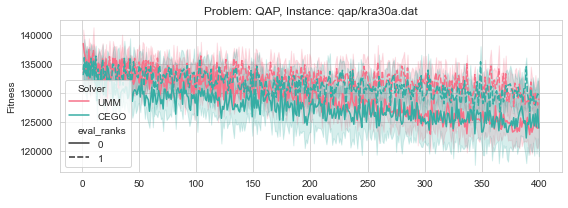

Instance:  qap/nug12.dat
Saving to img/fitness_real_qap_nug12_dat.pdf


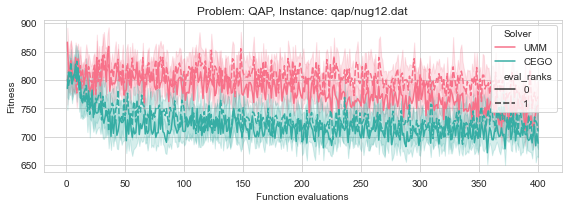

Instance:  qap/kra30b.dat
Saving to img/fitness_real_qap_kra30b_dat.pdf


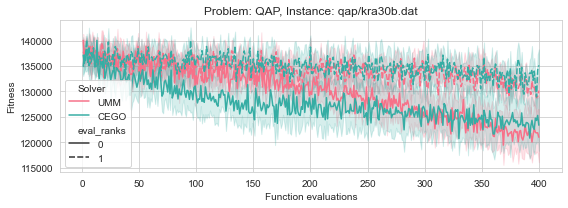

Instance:  qap/kra32.dat
Saving to img/fitness_real_qap_kra32_dat.pdf


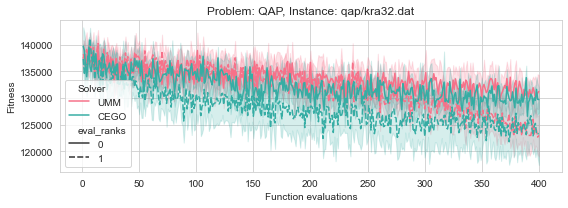

Instance:  qap/nug30.dat
Saving to img/fitness_real_qap_nug30_dat.pdf


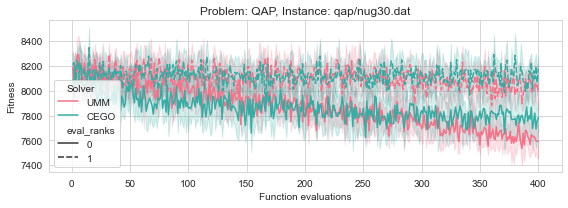

Instance:  LOP-synthetic,seed=123456,n=20,m=200,phi=0.5
Saving to img/fitness_real_LOP-synthetic,seed=123456,n=20,m=200,phi=0_5.pdf


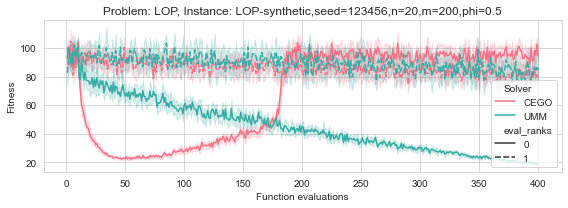

Instance:  pfsp/rec13.txt
Saving to img/fitness_real_pfsp_rec13_txt.pdf


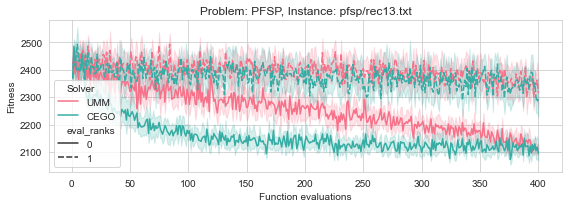

Instance:  pfsp/rec05.txt
Saving to img/fitness_real_pfsp_rec05_txt.pdf


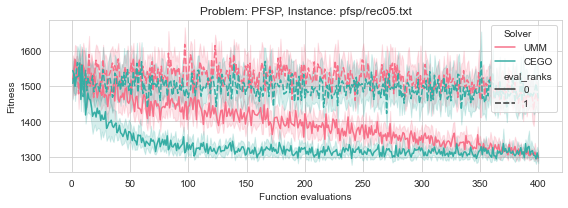

Instance:  pfsp/rec31.txt
Saving to img/fitness_real_pfsp_rec31_txt.pdf


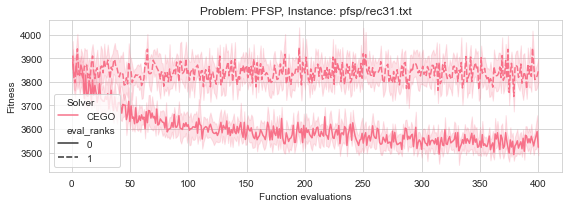

Instance:  pfsp/rec19.txt
Saving to img/fitness_real_pfsp_rec19_txt.pdf


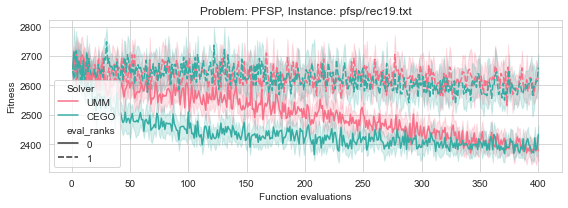

In [18]:
for inst in dfreal.instance.drop_duplicates().values:#selected.instance_name:# ['tho30']:# selected.instance_name:
    print("Instance: ", inst)
    df = dfreal[dfreal.instance.str.contains(inst)]
    if len(df) == 0: 
        print("No data for {inst}")
        continue
    plt.figure(figsize=(8,3))
    palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
    g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver',style='eval_ranks', data=df, palette=palette)
    g.set_title('Problem: ' + df.Problem.iloc[0] + ', Instance: ' + inst)
    plt.tight_layout()
    filename = 'img/fitness_real_' + df.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
    print("Saving to " + filename)
    plt.savefig(filename)
    plt.show()

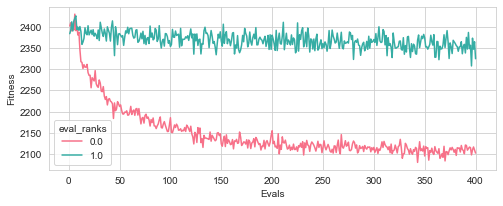

In [26]:
import pyreadr
lis = []
for filename in glob.glob("./cegores-er*"):
    aux =  pyreadr.read_r(filename)[None]
    lis.append(aux)
dfcegores = pd.concat(lis, sort = True)
plt.figure(figsize=(8,3))
palette = sns.color_palette("husl", 2)
g = sns.lineplot(x='Evals',y='Fitness',hue='eval_ranks', data=dfcegores, palette=palette,ci=None)


In [24]:
dfcegores.groupby(['Evals','eval_ranks']).mean()


Fitness  seed         time
Evals eval_ranks                                
1     0.0         2383.500000  15.5  1340.784067
      1.0         2383.500000  15.5  1311.861967
2     0.0         2391.433333  15.5  1340.784067
      1.0         2391.433333  15.5  1311.861967
3     0.0         2411.400000  15.5  1340.784067
...                       ...   ...          ...
398   1.0         2347.033333  15.5  1311.861967
399   0.0         2364.433333  15.5  1340.784067
      1.0         2364.433333  15.5  1311.861967
400   0.0         2324.600000  15.5  1340.784067
      1.0         2324.600000  15.5  1311.861967

[800 rows x 3 columns]

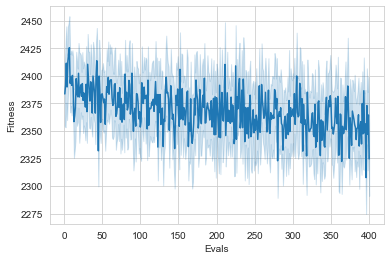

<AxesSubplot:xlabel='Evals', ylabel='Fitness'>

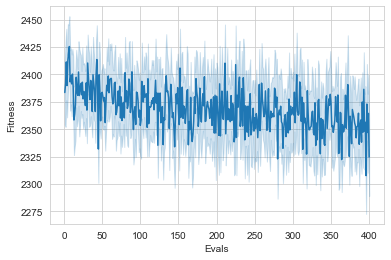

In [23]:

sns.lineplot(x='Evals',y='Fitness', data=dfcegores[dfcegores['eval_ranks']==0], palette=palette)
plt.show()
sns.lineplot(x='Evals',y='Fitness', data=dfcegores[dfcegores['eval_ranks']==1], palette=palette)

In [31]:
# # tiempo de ejecucion cego R
# a = dfcegores['Evals'] == dfcegores['Evals'].max()
# a = a & (dfcegores.Instance.str.contains('rec13'))
# # a = a & dfreal.Solver.str.contains('CEGO')
# dfcegores[a].time.mean()

1306.5989000000002

In [27]:
# tiempo de ejecucion cego python
# plt.plot(dfcegores[dfcegores['eval_ranks']==0].Fitness- 
# dfcegores.iloc[0]
# a = dfreal['Function evaluations'] == dfreal['Function evaluations'].max()
# a = a & (dfreal.instance.str.contains('rec13'))
# a = a & dfreal.Solver.str.contains('CEGO')
# dfreal[a].run_time.mean()

141604.84413475412

## Summary of the results

Table with the summary of the results

In [22]:
# The maximum time per seed and evaluation is the final time. 
dftime = dfreal.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = dfreal[dfreal['Solver'] == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = dfreal.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
# Fix instance names
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df['Instance'] = df['Instance'].str.replace('.txt','').str.replace('.dat', '')
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO F. evaluations','CEGO Runtime','UMM Runtime']]
df

Problem       Instance  CEGO_Fitness_mean CEGO_Fitness_std  \
11     LOP       N-p50-02            21767.3          (254.9)   
10     LOP       N-p50-01            21034.3          (183.9)   
1      LOP    N-t1d100.02            78834.0          (477.8)   
0      LOP    N-t1d100.01            78012.0          (432.1)   
12     LOP       N-atp111              668.5            (9.4)   
13     LOP       N-atp134              856.4           (12.2)   
16     LOP   N-be75np_150          3669753.9        (74292.3)   
2      LOP    N-t1d150.01           186969.0         (2094.6)   
14     LOP  N-be75eec_150          1592220.8        (29945.9)   
7      LOP    N-t2d150.02            22036.0          (744.7)   
6      LOP    N-t2d150.01            22207.3         (1667.3)   
3      LOP    N-t1d150.02           183414.7          (779.2)   
5      LOP    N-t1d200.02           331730.9         (2819.7)   
8      LOP    N-t2d200.01            54043.6         (1477.6)   
9      LOP    N-t2d200.02            52787.0         (4194.2)   
4      LOP    N-t1d200.01           333804.1         (1191.9)   
15     LOP  N-be75eec_250          5098734.4       (172874.0)   
17     LOP   N-be75np_250         10818828.5       (127722.3)   
18    PFSP          rec05             1317.9           (25.1)   
19    PFSP          rec13             2128.2           (25.0)   
20    PFSP          rec19             2398.6           (19.8)   
24     QAP          nug12              624.2           (26.3)   
22     QAP         kra30b           120192.0         (1778.1)   
26     QAP          tho30           192416.0         (2584.2)   
21     QAP         kra30a           119872.0         (1746.7)   
25     QAP          nug30             7486.8           (40.4)   
23     QAP          kra32           115907.0         (4663.4)   

    UMM_Fitness_mean UMM_Fitness_std     Confidence interval  \
11           21746.6         (645.4)         [-458.6, 500.0]   
10           21161.8         (657.4)         [-606.0, 351.0]   
1            76860.7         (864.0)        [1303.8, 2642.8]   
0            76499.3        (1099.7)         [696.4, 2329.0]   
12             596.6          (17.0)            [58.8, 85.0]   
13             760.1          (23.4)           [78.4, 114.2]   
16         3216907.1       (72239.3)    [383998.5, 521695.1]   
2           179615.6        (1731.5)        [5543.3, 9163.5]   
14         1418578.9       (56557.7)    [130141.0, 217142.8]   
7            14718.4         (677.5)        [6648.3, 7986.9]   
6            15136.9         (745.9)        [5817.1, 8323.7]   
3           177524.2        (1165.6)        [4949.2, 6831.8]   
5           319786.2        (2265.6)       [9533.6, 14355.8]   
8            33389.0        (1984.0)      [19001.4, 22307.8]   
9            35589.0        (2319.6)      [13948.0, 20448.0]   
4           323501.4        (1385.7)       [9086.4, 11519.0]   
15         4430408.5      (110233.0)    [530352.4, 806299.4]   
17         9582261.7      (258176.8)  [1040022.9, 1433110.7]   
18            1332.5          (15.6)            [-34.5, 5.3]   
19            2163.6          (28.1)          [-60.4, -10.4]   
20            2405.2          (12.8)            [-22.5, 9.3]   
24             661.2          (17.8)          [-58.3, -15.7]   
22          119923.0        (3459.6)       [-2379.5, 2917.5]   
26          191586.4        (4342.0)       [-2582.9, 4242.1]   
21          119502.0        (1827.5)       [-1309.8, 2049.8]   
25            7472.4          (83.6)           [-49.0, 77.8]   
23          116898.0        (4343.1)       [-5226.3, 3244.3]   

    CEGO F. evaluations  CEGO Runtime  UMM Runtime  
11                315.1         144.5          0.5  
10                305.8         144.6          0.5  
1                 156.0         144.7          1.8  
0                 158.3         145.1          1.9  
12                137.9         145.1          2.3  
13                116.5         145.0          3.3  
16                

In [23]:
print(df.to_latex(index=False))

\begin{tabular}{llrlrllrrr}
\toprule
Problem &       Instance &  CEGO\_Fitness\_mean & CEGO\_Fitness\_std &  UMM\_Fitness\_mean & UMM\_Fitness\_std &     Confidence interval &  CEGO F. evaluations &  CEGO Runtime &  UMM Runtime \\
\midrule
    LOP &       N-p50-02 &            21767.3 &          (254.9) &           21746.6 &         (645.4) &         [-458.6, 500.0] &                315.1 &         144.5 &          0.5 \\
    LOP &       N-p50-01 &            21034.3 &          (183.9) &           21161.8 &         (657.4) &         [-606.0, 351.0] &                305.8 &         144.6 &          0.5 \\
    LOP &    N-t1d100.02 &            78834.0 &          (477.8) &           76860.7 &         (864.0) &        [1303.8, 2642.8] &                156.0 &         144.7 &          1.8 \\
    LOP &    N-t1d100.01 &            78012.0 &          (432.1) &           76499.3 &        (1099.7) &         [696.4, 2329.0] &                158.3 &         145.1 &          1.9 \\
    LOP &       